In [338]:
#*****************************************************************************************************
# Fix settings concerning the ansatz, optimisation and backend
#*****************************************************************************************************
from time import time 
import pickle 
import numpy as np
!pip install jax

from discopy import Ty, Id, Box, Diagram, Word
from discopy.rigid import Cup, Cap, Functor, Swap
from discopy.quantum.circuit import bit, qubit
from discopy.quantum import Measure
from discopy.quantum.tk import to_tk
from discopy.quantum.tk import Circuit as tk_Circuit_inDCP

from pytket import Circuit as tk_Circuit

#-----------------------------
# atomic pregroup grammar types
#-----------------------------
s, n = Ty('S'), Ty('N')

#----------------------------------------
# settings concerning the ansaetze
#----------------------------------------
q_s = 1        # number of qubits for sentence type s
q_n = 1        # number of qubits for noun type n
depth = 1      # number of IQP layers for non-single-qubit words
p_n = 3        # number of parameters for a single-qubit word (noun); valued in {1,2,3}.

#----------------------------------------
# Parameters concerning the optimisation
#----------------------------------------
n_runs = 20       # number of runs over training procedure
niter  = 2000     # number of iterations for any optimisation run of training.


In [339]:
#******************************************
# Data import
#******************************************

# import train and test datasets: the data entries are all strings of the form 'label sentence' 
# with the label in {0,1} and with the sentence of the form "word1_POStag1 word2_POStag2 ..."

with open('../datasets/mc_train_data.txt') as f:
    training_data_raw = f.readlines()
    
with open('../datasets/mc_dev_data.txt') as f:
    dev_data_raw = f.readlines()

with open('../datasets/mc_test_data.txt') as f:
    testing_data_raw = f.readlines()

In [340]:
#***************************************************************
# Turn the raw input data into data structures convenient below
#***************************************************************

vocab = dict()          # dictionary to be filled with the vocabulary in the form { word : POStag }
data = dict()           # dictionary to be filled with all the data (train, dev and test subsets); entries of the 
                        # form { sentence : label } with label encoding '1' as [1.0, 0.0] and '0' as [0.0, 1.0]
training_data = []      # list of sentences in the train dataset as strings "word1 word2 ..."
dev_data = []           # list of sentences in the dev dataset as strings "word1 word2 ..."
testing_data = []       # list of sentences in the test dataset as strings "word1 word2 ..."

# Go through the train data
for sent in training_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    training_data.append(sentence)
    label = np.array([1.0, 0.0]) if sent[0] == '1' else np.array([0.0, 1.0])
    data[sentence] = label

# Go through the dev data
for sent in dev_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    dev_data.append(sentence)
    label = np.array([1.0, 0.0]) if sent[0] == '1' else np.array([0.0, 1.0])
    data[sentence] = label
    
# Go through the test data
for sent in testing_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    testing_data.append(sentence)
    label = np.array([1.0, 0.0]) if sent[0] == '1' else np.array([0.0, 1.0])
    data[sentence] = label

In [341]:
#*****************************************************
# The sentences as diagrams via CFG production rules
#*****************************************************

#----------------------------
# Further POS tags:
#----------------------------
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

#----------------------------
# The vocabulary in DisCoPy
#----------------------------
vocab_dict_boxes = dict()
for word, tag in vocab.items():
    if tag == 'N':
        vocab_dict_boxes.update({word: Word(word, n)})
    if tag == 'TV':
        vocab_dict_boxes.update({word: Word(word, tv)})
    if tag == 'ADJ':
        vocab_dict_boxes.update({word: Word(word, adj)})

#-------------------------------------
# The CFG production rules as boxes
#-------------------------------------
r0 = Box('R0', nphr @ vphr, s)
r1 = Box('R1', tv @ nphr, vphr)
r2 = Box('R2', adj @ n, nphr)
r3 = Box('R3', iv, vphr)
r4 = Box('R4', n, nphr)

#---------------------------------------------
# The needed grammatical sentence structures
#---------------------------------------------
grammar_dict = {
    'N_TV_N': ((Id(n @ tv) @ r4) >> (r4 @ r1) >> r0),
    'N_TV_ADJ_N': ((Id(n @ tv) @ r2) >> (r4 @ r1) >> r0),
    'ADJ_N_TV_N': ((Id(adj @ n @ tv) @ r4) >> (r2 @ r1) >> r0),
}

#---------------------------------------------
# Create CFG diagrams for the sentences
#---------------------------------------------
sentences_dict = dict()
for sentstr in list(data.keys()):
    grammar_id = ''
    sentence = Id(Ty())
    for word in sentstr.split(' '):
        grammar_id += (vocab[word] + '_')
        sentence = sentence @ vocab_dict_boxes[word]
    grammar_id = grammar_id[:-1]
    sentence = sentence >> grammar_dict[grammar_id]
    sentences_dict.update({sentstr: [sentence, grammar_id]})

In [342]:
#***************************************************************
# Translation to pregroup grammar 
#***************************************************************
from discopy.grammar.pregroup import draw

# From POS tags to Pregroup types:
ob_pg = {n: n, s: s, adj: n @ n.l, tv: n.r @ s @ n.l, vphr:  n.r @ s, nphr: n}

# From CFG rules to Pregroup reductions: 
ar_pg = {
    r0: Cup(n, n.r) @ Id(s),
    r1: Id(n.r @ s) @ Cup(n.l, n),
    r2: Id(n) @ Cup(n.l, n),
    r3: Id(n.r @ s),
    r4: Id(n)
}

# The vocabulary as DisCoPy boxes with pregroup types
vocab_pg = [Word(vocab_dict_boxes[word].name, ob_pg[vocab_dict_boxes[word].cod]) for word in vocab.keys()]

# The mapping of morphisms
ar_pg.update({vocab_dict_boxes[word]: Word(vocab_dict_boxes[word].name, ob_pg[vocab_dict_boxes[word].cod]) for word in vocab.keys()})

# The functor that translates from CFG to pregroup
t2p = Functor(ob_pg, ar_pg)

sentences_pg_dict = dict()
for sentstr in sentences_dict:
    sentences_pg_dict.update({sentstr: [t2p(sentences_dict[sentstr][0]), sentences_dict[sentstr][1]]})

In [343]:
#******************************************************************************************************
# (Optional) For visualisation: the sentences as pregroup diagrams -- before 'bending nouns around'
#******************************************************************************************************

#for sentstr in sentences_pg_dict:
#    sentences_pg_dict[sentstr][0].draw()

In [344]:
#******************************************************
# Bending the nouns around
#******************************************************
sentences_pg_psr_dict = dict()

for sentstr in sentences_pg_dict:
    grammar_id = sentences_pg_dict[sentstr][1]
    num_words = len(grammar_id.split('_'))
    words = sentences_pg_dict[sentstr][0][:num_words].boxes
    grammar = sentences_pg_dict[sentstr][0][num_words:]
    if grammar_id == 'N_TV_N':
        noun1 = Box(words[0].name, n.r, Ty())
        noun2 = Box(words[2].name, n.l, Ty())
        words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
    if grammar_id == 'ADJ_N_TV_N':
        noun1 = Box(words[1].name, n.l, Ty())
        noun2 = Box(words[3].name, n.l, Ty())
        words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ Id(n) @ noun2)
    if grammar_id == 'N_TV_ADJ_N':
        noun1 = Box(words[0].name, n.r, Ty())
        noun2 = Box(words[3].name, n.l, Ty())
        words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
    # add newly wired sentence to dictionary
    sentence = words_new >> grammar
    # Yank snakes and add to dictionary
    sentences_pg_psr_dict.update({sentstr: sentence.normal_form()})

# Now for the vocab
vocab_psr = []
for word in vocab_pg:
    if word.cod == Ty('N'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)

In [345]:
#******************************************************************************************************
# (Optional) For visualisation: the sentences as pregroup diagrams -- after 'bending nouns around'
#******************************************************************************************************
#for sentstr in sentences_pg_psr_dict:
#    sentences_pg_psr_dict[sentstr].draw()

In [346]:
from discopy import Circuit
from discopy.quantum import qubit, Id
from discopy.quantum.gates import Rx, Rz, CRx, CRz, Ry

def Sim14ansatz(n_qubits, params) -> Circuit:
    import numpy as np

    def layer(thetas):
        sublayer1 = Id().tensor(*(Ry(theta) for theta in thetas[:n_qubits]))
        for i in range(n_qubits):
            src = i
            tgt = (i - 1) % n_qubits
            sublayer1 = sublayer1.CRx(thetas[n_qubits + i], src, tgt)

        sublayer2 = Id().tensor(*(Ry(theta) for theta in thetas[2 * n_qubits: 3 * n_qubits]))
        for i in range(n_qubits, 0, -1):
            src = i % n_qubits
            tgt = (i + 1) % n_qubits
            sublayer2 = sublayer2.CRx(thetas[-i], src, tgt)

        return sublayer1 >> sublayer2

    params_shape = np.shape(params)

    if n_qubits == 1:
        circuit = Rx(params[0]) >> Rz(params[1]) >> Rx(params[2])
    elif len(params_shape) != 2 or params_shape[1] != 4 * n_qubits:
        raise ValueError(f"Expected params of shape (depth, {4 * n_qubits})")
    else:
        depth = params_shape[0]
        circuit = Id(qubit ** n_qubits).then(*(layer(params[i]) for i in range(depth)))

    return circuit

def Sim15ansatz(n_qubits, params) -> Circuit:
    import numpy as np

    def layer(thetas):
        sublayer1 = Id().tensor(*(Ry(theta) for theta in thetas[:n_qubits]))
        for i in range(n_qubits):
            src = i
            tgt = (i - 1) % n_qubits
            sublayer1 = sublayer1.CX(src, tgt)

        sublayer2 = Id().tensor(*(Ry(theta) for theta in thetas[n_qubits:]))
        for i in range(n_qubits, 0, -1):
            src = i % n_qubits
            tgt = (i + 1) % n_qubits
            sublayer2 = sublayer2.CX(src, tgt)

        return sublayer1 >> sublayer2

    params_shape = np.shape(params)

    if n_qubits == 1:
        circuit = Rx(params[0]) >> Rz(params[1]) >> Rx(params[2])
    elif len(params_shape) != 2 or params_shape[1] != 2 * n_qubits:
        raise ValueError(f"Expected params of shape (depth, {2 * n_qubits})")
    else:
        depth = params_shape[0]
        circuit = Id(qubit ** n_qubits).then(*(layer(params[i]) for i in range(depth)))

    return circuit

def LayeredEntanglingAnsatz(n_qubits, params):
    def entangling_layer(thetas):
        layer_circuit = Id()
        # Apply CRy entangling gates between adjacent qubits
        for i in range(n_qubits):
            layer_circuit = layer_circuit @ CRz(thetas[i], i, (i + 1) % n_qubits)

        # Introduce CZZ gates for further entanglement
        for i in range(0, n_qubits, 2):
            layer_circuit = layer_circuit @ CRx(i, (i + 1) % n_qubits)

        # Swap qubits to add connections across the layer
        for i in range(1, n_qubits, 2):
            layer_circuit = layer_circuit @ Swap(i, (i + 1) % n_qubits)

        return layer_circuit

    def rotation_layer(thetas):
        # Single-qubit parameterized rotations Rx, Ry, Rz for each qubit
        rot_circuit = Id().tensor(*(Rx(thetas[i]) >> Ry(thetas[n_qubits + i]) >> Rz(thetas[2 * n_qubits + i]) 
                                    for i in range(n_qubits)))
        return rot_circuit

    # Building the circuit with alternating rotation and entangling layers
    depth = params.shape[0]
    circuit = Id(qubit ** n_qubits)
    for i in range(depth):
        circuit = circuit >> rotation_layer(params[i]) >> entangling_layer(params[i, 3 * n_qubits:])
    
    return circuit

In [347]:
#*****************************************************
# Translation to quantum circuits
#*****************************************************
from discopy.quantum import Ket, IQPansatz, Bra
from discopy.quantum.gates import sqrt, H, CZ, Rz, Rx, CX
from discopy.quantum.circuit import Id
from discopy import CircuitFunctor
from discopy.quantum.circuit import Circuit as DCP_Circuit

ob = {s: q_s, n: q_n}                           # assignment of number of qubits to atomic grammatical types
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   # the form in which it is needed for discopy's cqmap module

#-----------------------------------------
# parametrised part of ansaetze
#-----------------------------------------

def single_qubit_iqp_ansatz(params):
    if len(params) == 1:
        return Rx(params[0])  
    if len(params) == 2:
        return Rx(params[0]) >> Rz(params[1])
    if len(params) == 3:
        return Sim14ansatz(1, params)       

def ansatz_state(state, params):  
    arity = sum(ob[Ty(factor.name)] for factor in state.cod)
    if arity == 1:
        return Ket(0) >> single_qubit_iqp_ansatz(params)
    else:
        return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params):  
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    if arity == 1:
        return single_qubit_iqp_ansatz(params) >> Bra(0)
    else:
        return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box, params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

#----------------------------------------------------------
# Define parametrised functor to quantum circuits
#----------------------------------------------------------

def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})
    return CircuitFunctor(ob_cqmap, ar)

In [348]:
#*****************************************************
# The functions to deal with the parametrisation
#*****************************************************

def param_shapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            if arity == 1:
                parshapes.append((p_n,))       
            if arity != 1:
                parshapes.append((depth, arity-1))
    return parshapes

def rand_params(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
         params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i]))))
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

In [349]:
#****************************************
# The parameters of the current model
#****************************************

par_shapes = param_shapes(vocab_psr)
rand_unshaped_pars = rand_params(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     40


In [350]:
#**************************************************************
# (Optional) Quantum circuit diagrams for the sentences 
#**************************************************************

#func = F(rand_shaped_pars)

#for sentstr in sentences_pg_psr_dict:
#    func(sentences_pg_psr_dict[sentstr]).draw(draw_box_labels=True, figsize=(5, 5), nodesize = 0.3)

In [351]:
#********************************************************************************************
# Encode data such that the circuits (for one call of cost function etc.) can be sent as one
# job to quantum hardware.
#********************************************************************************************

train_labels = []
train_circuits_pg_psr = []
for sentstr in training_data:
    train_circuits_pg_psr.append(sentences_pg_psr_dict[sentstr])
    train_labels.append(np.array(data[sentstr]))
train_labels = np.array(train_labels)

dev_labels = []
dev_circuits_pg_psr = []
for sentstr in dev_data:
    dev_circuits_pg_psr.append(sentences_pg_psr_dict[sentstr])
    dev_labels.append(np.array(data[sentstr]))
dev_labels = np.array(dev_labels)

test_labels = []
test_circuits_pg_psr = []
for sentstr in testing_data:
    test_circuits_pg_psr.append(sentences_pg_psr_dict[sentstr])
    test_labels.append(np.array(data[sentstr]))
test_labels = np.array(test_labels)

In [352]:
#**********************************************************************************************************
# The cost function for optimisation and the error functions 
#**********************************************************************************************************
from jax import numpy as jnp
from jax import jit

def get_cost(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    train_circuits = [func(circ) for circ in train_circuits_pg_psr]
    results = DCP_Circuit.eval(*train_circuits)
    results_tweaked = [jnp.abs(jnp.array(res.array) - 1e-9) for res in results]
    pred_labels_distrs = [res / jnp.sum(res) for res in results_tweaked]
    cross_entropies = jnp.array([jnp.sum(train_labels[s] * jnp.log2(pred_labels_distrs[s])) for s in range(len(train_labels))])
    return -1 / len(training_data) * jnp.sum(cross_entropies)

def get_train_error(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    train_circuits = [func(circ) for circ in train_circuits_pg_psr]
    results = DCP_Circuit.eval(*train_circuits)
    results_tweaked = [jnp.abs(jnp.array(res.array) - 1e-9) for res in results]
    pred_labels_distrs = [res / jnp.sum(res) for res in results_tweaked]
    assert len(pred_labels_distrs[0]) == 2  # rounding only makes sense if labels are binary tuples
    pred_labels = [jnp.round(res) for res in pred_labels_distrs]
    error = 0.0
    for i in range(len(pred_labels)):
        diff = jnp.sum(jnp.abs(train_labels[i] - pred_labels[i]))
        error += jnp.min(jnp.array([diff, 1.0]))
    return error * 100 / len(training_data)

def get_dev_error(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    dev_circuits = [func(circ) for circ in dev_circuits_pg_psr]
    results = DCP_Circuit.eval(*dev_circuits)
    results_tweaked = [jnp.abs(jnp.array(res.array) - 1e-9) for res in results]
    pred_labels_distrs = [res / jnp.sum(res) for res in results_tweaked]
    assert len(pred_labels_distrs[0]) == 2  # rounding only makes sense if labels are binary tuples
    pred_labels = [jnp.round(res) for res in pred_labels_distrs]
    error = 0.0
    for i in range(len(pred_labels)):
        diff = jnp.sum(jnp.abs(dev_labels[i] - pred_labels[i]))
        error += jnp.min(jnp.array([diff, 1.0]))
    return error * 100 / len(dev_data)


def get_test_error(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    test_circuits = [func(circ) for circ in test_circuits_pg_psr]
    results = DCP_Circuit.eval(*test_circuits)
    results_tweaked = [jnp.abs(jnp.array(res.array) - 1e-9) for res in results]
    pred_labels_distrs = [res / jnp.sum(res) for res in results_tweaked]
    assert len(pred_labels_distrs[0]) == 2  # rounding only makes sense if labels are binary tuples
    pred_labels = [jnp.round(res) for res in pred_labels_distrs]
    error = 0.0
    for i in range(len(pred_labels)):
        diff = jnp.sum(jnp.abs(test_labels[i] - pred_labels[i]))
        error += jnp.min(jnp.array([diff, 1.0]))
    return error * 100 / len(testing_data)

In [353]:
#*************************************************************************************************
# Define the jitted versions of above three functions. Then one by one do a 
# loop over two calls to let jit do its thing so that function call is fast when doing optimisation.
#*************************************************************************************************

get_cost_jit = jit(get_cost)
get_train_error_jit = jit(get_train_error)
get_dev_error_jit = jit(get_dev_error)
get_test_error_jit = jit(get_test_error)

In [354]:
for i in range(2):
    rand_unshaped_pars = rand_params(par_shapes)
    print('-------------')
    start = time()
    print('Cost: ', get_cost_jit(rand_unshaped_pars))
    print('Time taken for this iteration: ', time()-start)

-------------
Cost:  1.1132514
Time taken for this iteration:  6.14484429359436
-------------
Cost:  0.83061635
Time taken for this iteration:  0.0


In [355]:
for i in range(2):
    rand_unshaped_pars = rand_params(par_shapes)
    print('-------------')
    start = time()
    print('Train Error: ', get_train_error_jit(rand_unshaped_pars))
    print('Time taken for this iteration: ', time()-start)

-------------
Train Error:  61.428574
Time taken for this iteration:  5.917524337768555
-------------
Train Error:  50.0
Time taken for this iteration:  0.0


In [356]:
for i in range(2):
    rand_unshaped_pars = rand_params(par_shapes)
    print('-------------')
    start = time()
    print('Dev Error: ', get_dev_error_jit(rand_unshaped_pars))
    print('Time taken for this iteration: ', time()-start)

-------------
Dev Error:  36.666668
Time taken for this iteration:  3.0053045749664307
-------------
Dev Error:  46.666668
Time taken for this iteration:  0.0009984970092773438


In [357]:
for i in range(2):
    rand_unshaped_pars = rand_params(par_shapes)
    print('-------------')
    start = time()
    print('Test Error: ', get_test_error_jit(rand_unshaped_pars))
    print('Time taken for this iteration: ', time()-start)

-------------
Test Error:  53.333336
Time taken for this iteration:  2.6451075077056885
-------------
Test Error:  43.333336
Time taken for this iteration:  0.0


In [358]:
#**********************************************************************************
# Minimization algorithm
#**********************************************************************************

# This is building on the minimizeSPSA function from the noisyopt package (https://github.com/andim/noisyopt);
# here only adjusted for our purposes (mostly with quantum implementations in mind)

def my_spsa(get_cost, get_train_error, x0,
            bounds=None, niter=100, a=1.0, c=1.0, alpha=0.602, gamma=0.101,
            print_iter=False, filename='spsa_output'):
    A = 0.01 * niter
    N = len(x0)
    if bounds is None:
        project = lambda x: x
    else:
        bounds = np.asarray(bounds)
        project = lambda x: np.clip(x, bounds[:, 0], bounds[:, 1])    
    param_history = []
    func_history = []
    error_history = []
    x = x0    
    
    # Loop over iterations
    for k in range(niter):
        if print_iter:
            print('-------------', '\n', 'iteration: ', k, sep='')
        start = time()
        
        # determine stepping parameters
        ak = a/(k+1.0+A)**alpha
        ck = c/(k+1.0)**gamma
        delta = np.random.choice([-1, 1], size=N)
        
        # move in + direction from previous x
        xplus = project(x + ck*delta)        
        if print_iter:
            print('Call for xplus')
        funcplus = get_cost(xplus)
        
        # move in - direction from previous x
        xminus = project(x - ck * delta)
        if print_iter:
            print('Call for xminus')
        funcminus = get_cost(xminus)
        
        # new step
        grad = (funcplus - funcminus) / (xplus-xminus)
        x = project(x - ak*grad)
        param_history.append(x)
        
        # determine current func and error
        current_func_value = get_cost(x)
        error = get_train_error(x)
        func_history.append(current_func_value)
        error_history.append(error)

        # save to file
        dump_data = {
            'param_history': param_history,
            'func_history': func_history,
            'error_history': error_history
        }
        with open(filename+'.pickle', 'wb') as file_handle:
            pickle.dump(dump_data, file_handle)
        
        if print_iter:
            print('Time taken for this iteration: ', time() - start)
    return param_history, func_history, error_history 

In [359]:
def my_spsa_enh(get_cost, get_train_error, x0, bounds=None, niter=100, a=1.0, c=1.0, 
                alpha=0.602, gamma=0.101, print_iter=False, filename='spsa_output', tolerance=1e-6):
    A = 0.01 * niter
    N = len(x0)
    
    # Bounds handling
    if bounds is None:
        project = lambda x: x
    else:
        bounds = np.asarray(bounds)
        project = lambda x: np.clip(x, bounds[:, 0], bounds[:, 1])    
    
    # History initialization
    param_history = []
    func_history = []
    error_history = []
    x = np.array(x0)
    
    for k in range(niter):
        if print_iter:
            print(f'-------------\nIteration: {k}')
        start = time()
        
        # Step size calculations
        ak = a / (k + 1.0 + A) ** alpha
        ck = c / (k + 1.0) ** gamma
        
        # Generate perturbation
        delta = np.random.choice([-1, 1], size=N)
        
        # Evaluate x+ and x- perturbations
        xplus = project(x + ck * delta)
        funcplus = get_cost(xplus)
        
        xminus = project(x - ck * delta)
        funcminus = get_cost(xminus)
        
        # Gradient approximation
        grad = (funcplus - funcminus) / (2 * ck * delta)
        
        # Update parameters
        x = project(x - ak * grad)
        param_history.append(x)
        
        # Evaluate function value and error
        current_func_value = get_cost(x)
        error = get_train_error(x)
        func_history.append(current_func_value)
        error_history.append(error)
        
        # Save periodically
        if k % 10 == 0 or k == niter - 1:
            dump_data = {
                'param_history': param_history,
                'func_history': func_history,
                'error_history': error_history
            }
            with open(filename + '.pickle', 'wb') as file_handle:
                pickle.dump(dump_data, file_handle)

        # Print time for iteration
        if print_iter:
            print(f"Time taken for this iteration: {time() - start:.4f} seconds")
        
        # Early stopping
        if k > 0 and abs(func_history[-1] - func_history[-2]) < tolerance:
            if print_iter:
                print(f"Converged at iteration {k}.")
            break

    return param_history, func_history, error_history


In [360]:
#************************************
# Quantum run: Adam Optimization Algorithm training and error calculation
#************************************

def my_adam_opt(get_cost, get_train_error, x0,
                bounds=None, niter=100, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8,
                print_iter=False, filename='adam_output', tolerance=1e-6):
    """
    Optimized implementation of the ADAM algorithm with consistent structure for quantum optimization tasks.
    """
    N = len(x0)
    
    # Bounds handling
    if bounds is None:
        project = lambda x: x
    else:
        bounds = np.asarray(bounds)
        project = lambda x: np.clip(x, bounds[:, 0], bounds[:, 1])

    # Initialize histories and moment vectors
    param_history = []
    func_history = []
    error_history = []
    m = np.zeros(N)  # First moment vector
    v = np.zeros(N)  # Second moment vector
    x = np.array(x0)

    # ADAM optimization loop
    for k in range(1, niter + 1):
        if print_iter:
            print(f'-------------\nIteration: {k}')
        start = time()

        # Gradient estimation using finite differences
        grad = np.zeros(N)
        delta = 1e-5
        for i in range(N):
            x_plus = x.copy()
            x_plus[i] += delta
            x_minus = x.copy()
            x_minus[i] -= delta
            grad[i] = (get_cost(x_plus) - get_cost(x_minus)) / (2 * delta)

        # Update biased first moment estimate
        m = beta1 * m + (1 - beta1) * grad
        # Update biased second moment estimate
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        # Compute bias-corrected estimates
        m_hat = m / (1 - beta1 ** k)
        v_hat = v / (1 - beta2 ** k)
        # Parameter update
        x = project(x - alpha * m_hat / (np.sqrt(v_hat) + epsilon))

        # Store history
        param_history.append(x.copy())
        
        # Evaluate cost and training error
        current_func_value = get_cost(x)
        error = get_train_error(x)
        func_history.append(current_func_value)
        error_history.append(error)

        # Save periodically or at the end
        if k % 10 == 0 or k == niter:
            dump_data = {
                'param_history': param_history,
                'func_history': func_history,
                'error_history': error_history
            }
            with open(filename + '.pickle', 'wb') as file_handle:
                pickle.dump(dump_data, file_handle)

        if print_iter:
            print(f"Time taken for this iteration: {time() - start:.4f} seconds")

        # Check for convergence
        if k > 1 and abs(func_history[-1] - func_history[-2]) < tolerance:
            if print_iter:
                print(f"Converged at iteration {k}.")
            break

    return param_history, func_history, error_history

In [361]:
#************************************
# Quantum run: Genetic Algorithm training and error calculation
#************************************

def initialize_population(pop_size, n_params):
    return np.random.rand(pop_size, n_params)

def evaluate_population(population, get_cost, get_train_error):
    costs = np.array([get_cost(ind) for ind in population])
    errors = np.array([get_train_error(ind) for ind in population])
    return costs, errors

def select_parents(population, costs):
    pop_size = len(population)
    parents = np.empty_like(population)
    for i in range(pop_size):
        tournament_indices = np.random.choice(pop_size, size=2, replace=False)
        winner = tournament_indices[np.argmin(costs[tournament_indices])]
        parents[i] = population[winner]
    return parents

def crossover(parents, crossover_rate=0.8):
    offspring = np.empty_like(parents)
    for i in range(0, len(parents), 2):
        if i + 1 < len(parents) and np.random.rand() < crossover_rate:
            crossover_point = np.random.randint(1, len(parents[0]))
            offspring[i, :crossover_point] = parents[i, :crossover_point]
            offspring[i, crossover_point:] = parents[i + 1, crossover_point:]
            offspring[i + 1, :crossover_point] = parents[i + 1, :crossover_point]
            offspring[i + 1, crossover_point:] = parents[i, crossover_point:]
        else:
            offspring[i] = parents[i]
            if i + 1 < len(parents):
                offspring[i + 1] = parents[i + 1]
    return offspring

def mutate(offspring, mutation_rate=0.1):
    for ind in offspring:
        if np.random.rand() < mutation_rate:
            mutation_vector = np.random.normal(0, 0.1, size=len(ind))
            ind += mutation_vector
            ind = np.clip(ind, 0, 1)
    return offspring

def genetic_algorithm(get_cost, get_train_error, x0, 
                     pop_size=10, niter=20, 
                     crossover_rate=0.8, mutation_rate=0.1, 
                     filename='ga_output'):
    n_params = len(x0)
    population = initialize_population(pop_size, n_params)
    param_history = []
    func_history = []
    error_history = []
    
    for k in range(niter):
        start = time()
        
        costs, errors = evaluate_population(population, get_cost, get_train_error)
        
        best_index = np.argmin(costs)
        param_history.append(population[best_index])
        func_history.append(costs[best_index])
        error_history.append(errors[best_index])
        
        parents = select_parents(population, costs)
        
        offspring = crossover(parents, crossover_rate)
        
        population = mutate(offspring, mutation_rate)

        dump_data = {
            'param_history': param_history,
            'func_history': func_history,
            'error_history': error_history
        }
        with open(filename+'.pickle', 'wb') as file_handle:
            pickle.dump(dump_data, file_handle)
        
        print(f"Iteration: {k}, Best Cost: {costs[best_index]}, Time taken: {time() - start}")

    return param_history, func_history, error_history

In [362]:
#*****************************************************
# Optimisation settings
#*****************************************************

bounds = [[0.0, 1.0] for ii in range(len(rand_unshaped_pars))]

c_fix = 0.1  
#leave alpha and gamma as the default (which is as recommended), i.e. alpha = 0.602 and gamma = 0.101

#-----------------------------------
# calculate well-educated guess for parameter 'a'. 
# (below calcucation follows the heuristics from: 
#  https://www.jhuapl.edu/SPSA/PDF-SPSA/Spall_Implementation_of_the_Simultaneous.PDF )
#-----------------------------------

desired_param_change = 0.005  # rough change of a parameter in early iterations.

alpha = 0.602     
A = niter*0.01    
c_0 = c_fix

a_est = 0.0
nruns = 1000
for l in range(nruns):
    rand_unshaped_pars = rand_params(par_shapes)
    delta_0 = np.array([np.random.randint(0,2) for i in range(len(rand_unshaped_pars))])*2\
              - np.array([1 for i in range(len(rand_unshaped_pars))])
    g0_estimate = (get_cost_jit(rand_unshaped_pars + c_0*delta_0) - get_cost_jit(rand_unshaped_pars - c_0*delta_0))/(2*c_0)
    a_est += np.abs(desired_param_change * ((A +1)**alpha) / g0_estimate )
a_est = a_est/nruns
print('Calculated good choice for a=', a_est)

Calculated good choice for a= 0.16731791


In [363]:
#**********************************************************
# Training the model: SPSA optimization
#**********************************************************
param_histories_spsa = []
cost_histories_spsa = np.zeros((n_runs, niter))
error_train_histories_spsa = np.zeros((n_runs, niter))

for i in range(n_runs):
    print('---------------------------------')
    print('Start run ', i+1)
    rand_unshaped_pars = rand_params(par_shapes)
    start = time()
    res = my_spsa(get_cost_jit, get_train_error_jit, rand_unshaped_pars,
                  bounds=bounds, niter=niter,
                  print_iter=False, filename=('RP_task_SPSAOutput_ECS_Run' + str(i)))
    param_histories_spsa.append(res[0])   
    cost_histories_spsa[i, :] = res[1]
    error_train_histories_spsa[i, :] = res[2]    
    print('run', i+1, 'done')
    print('Time taken: ', round(time() - start,2))

---------------------------------
Start run  1
run 1 done
Time taken:  42.2
---------------------------------
Start run  2
run 2 done
Time taken:  45.79
---------------------------------
Start run  3
run 3 done
Time taken:  45.69
---------------------------------
Start run  4
run 4 done
Time taken:  40.57
---------------------------------
Start run  5
run 5 done
Time taken:  42.4
---------------------------------
Start run  6
run 6 done
Time taken:  154.99
---------------------------------
Start run  7
run 7 done
Time taken:  151.1
---------------------------------
Start run  8
run 8 done
Time taken:  141.0
---------------------------------
Start run  9
run 9 done
Time taken:  140.48
---------------------------------
Start run  10
run 10 done
Time taken:  145.6
---------------------------------
Start run  11
run 11 done
Time taken:  137.54
---------------------------------
Start run  12
run 12 done
Time taken:  66.12
---------------------------------
Start run  13
run 13 done
Time take

In [364]:
#**********************************************************
# Training the model: Enhanced SPSA optimization 
#**********************************************************
param_histories_spsa_enh = []
cost_histories_spsa_enh = []
error_train_histories_spsa_enh = []

for i in range(n_runs):
    print('---------------------------------')
    print('Start run ', i+1)
    rand_unshaped_pars = rand_params(par_shapes)
    start = time()
    res = my_spsa_enh(get_cost_jit, get_train_error_jit, rand_unshaped_pars,
                  bounds=bounds, niter=niter, a=a_est, c=c_fix,
                  print_iter=False, filename=('RP_task_SPSA_ENH_Output_ECS_Run' + str(i)))
    param_histories_spsa_enh.append(res[0])   
    cost_histories_spsa_enh.append(res[1])
    error_train_histories_spsa_enh.append(res[2])   
    print('run', i+1, 'done')
    print('Time taken: ', round(time() - start,2))

---------------------------------
Start run  1
run 1 done
Time taken:  8.75
---------------------------------
Start run  2
run 2 done
Time taken:  0.9
---------------------------------
Start run  3
run 3 done
Time taken:  17.88
---------------------------------
Start run  4
run 4 done
Time taken:  1.09
---------------------------------
Start run  5
run 5 done
Time taken:  5.72
---------------------------------
Start run  6
run 6 done
Time taken:  17.24
---------------------------------
Start run  7
run 7 done
Time taken:  5.96
---------------------------------
Start run  8
run 8 done
Time taken:  4.11
---------------------------------
Start run  9
run 9 done
Time taken:  4.95
---------------------------------
Start run  10
run 10 done
Time taken:  18.69
---------------------------------
Start run  11
run 11 done
Time taken:  0.18
---------------------------------
Start run  12
run 12 done
Time taken:  3.87
---------------------------------
Start run  13
run 13 done
Time taken:  5.22
--

In [ ]:
#**********************************************************
# Training the model: Adam optimization
#**********************************************************
param_histories_adam_opt = []
cost_histories_adam_opt = []
error_train_histories_adam_opt = []

for i in range(n_runs):
    print('---------------------------------')
    print('Start run ', i+1)
    rand_unshaped_pars = rand_params(par_shapes)
    start = time()
    res = my_adam_opt(get_cost_jit, get_train_error_jit, rand_unshaped_pars,
                  bounds=bounds, niter=niter,
                  print_iter=False, filename=('RP_task_ADAMOutput_ECS_Run' + str(i)))
    param_histories_adam_opt.append(res[0])   
    cost_histories_adam_opt.append(res[1])
    error_train_histories_adam_opt.append(res[2])    
    print('run', i+1, 'done')
    print('Time taken: ', round(time() - start,2))

---------------------------------
Start run  1
run 1 done
Time taken:  164.54
---------------------------------
Start run  2


In [ ]:
#**********************************************************
# Training the model: Genetic Algorithm optimization
#**********************************************************
param_histories_ga = []
cost_histories_ga = np.zeros((n_runs, niter))
error_train_histories_ga = np.zeros((n_runs, niter))

for i in range(n_runs):
    print('---------------------------------')
    print('Start run ', i+1)
    rand_unshaped_pars = rand_params(par_shapes)
    start = time()
    res = genetic_algorithm(get_cost_jit, get_train_error_jit, rand_unshaped_pars,
                  niter=niter,
                  filename=('RP_task_SPSAOutput_ECS_Run' + str(i)))
    param_histories_ga.append(res[0])   
    cost_histories_ga[i, :] = res[1]
    error_train_histories_ga[i, :] = res[2]    
    print('run', i+1, 'done')
    print('Time taken: ', round(time() - start,2))

---------------------------------
Start run  1
Iteration: 0, Best Cost: 0.7233647108078003, Time taken: 0.020155668258666992
Iteration: 1, Best Cost: 0.7233647108078003, Time taken: 0.015089988708496094
Iteration: 2, Best Cost: 0.6915066242218018, Time taken: 0.0148162841796875
Iteration: 3, Best Cost: 0.6915066242218018, Time taken: 0.013599872589111328
Iteration: 4, Best Cost: 0.6915066242218018, Time taken: 0.012113809585571289
Iteration: 5, Best Cost: 0.6678491234779358, Time taken: 0.016042232513427734
Iteration: 6, Best Cost: 0.6678491234779358, Time taken: 0.015251636505126953
Iteration: 7, Best Cost: 0.6678491234779358, Time taken: 0.015593290328979492
Iteration: 8, Best Cost: 0.6678491234779358, Time taken: 0.013542890548706055
Iteration: 9, Best Cost: 0.667438805103302, Time taken: 0.01605057716369629
Iteration: 10, Best Cost: 0.667438805103302, Time taken: 0.01456761360168457
Iteration: 11, Best Cost: 0.6467538475990295, Time taken: 0.012090921401977539
Iteration: 12, Best C

In [ ]:
#************************************
# Calculate costs and errors: SPSA Optimization
#************************************

# Calculate dev errors
error_dev_histories_spsa = np.zeros((n_runs,niter))
param_histories_spsa = param_histories_spsa
for i in range(n_runs):
    dev_errors_spsa = []
    for params in param_histories_spsa[i]:
        dev_errors_spsa.append(get_dev_error_jit(params))
    error_dev_histories_spsa[i,:] = dev_errors_spsa

# Calculate test errors
error_test_histories_spsa = np.zeros((n_runs,niter))

for i in range(n_runs):
    test_errors_spsa = []
    for params in param_histories_spsa[i]:
        test_errors_spsa.append(get_test_error_jit(params))
    error_test_histories_spsa[i,:] = test_errors_spsa

# Calculate average cost and errors
cost_history_mean_spsa = np.zeros(niter)
error_train_history_mean_spsa = np.zeros(niter)
error_dev_history_mean_spsa = np.zeros(niter)
error_test_history_mean_spsa = np.zeros(niter)

for i in range(niter):
    cost_history_mean_spsa[i] = np.mean(cost_histories_spsa[:,i])
    error_train_history_mean_spsa[i] = np.mean(error_train_histories_spsa[:,i]) 
    error_dev_history_mean_spsa[i] = np.mean(error_dev_histories_spsa[:,i]) 
    error_test_history_mean_spsa[i] = np.mean(error_test_histories_spsa[:,i]) 

In [ ]:
#************************************
# Calculate costs and errors: Enhanced SPSA Optimization
#************************************

# Calculate dev errors
error_dev_histories_spsa_enh = []
param_histories_spsa_enh = param_histories_spsa_enh
for i in range(n_runs):
    dev_errors_spsa_enh = []
    for params in param_histories_spsa_enh[i]:
        dev_errors_spsa_enh.append(get_dev_error_jit(params))
    error_dev_histories_spsa_enh.append(dev_errors_spsa_enh)

# Calculate test errors
error_test_histories_spsa_enh = []

for i in range(n_runs):
    test_errors_spsa_enh = []
    for params in param_histories_spsa_enh[i]:
        test_errors_spsa_enh.append(get_test_error_jit(params))
    error_test_histories_spsa_enh.append(test_errors_spsa_enh)


# Convert lists to arrays
cost_histories_spsa_enh = np.array(cost_histories_spsa_enh, dtype=object)
error_train_histories_spsa_enh = np.array(error_train_histories_spsa_enh, dtype=object)
error_dev_histories_spsa_enh = np.array(error_dev_histories_spsa_enh, dtype=object)
error_test_histories_spsa_enh = np.array(error_test_histories_spsa_enh, dtype=object)

# Find the maximum length across all runs
max_len = max(len(run) for run in cost_histories_spsa_enh)

# Pad all histories to the same length
def pad_to_max_len(history, max_len):
    return np.array([np.pad(run, (0, max_len - len(run)), constant_values=np.nan) for run in history])

cost_histories_padded_spsa_enh = pad_to_max_len(cost_histories_spsa_enh, max_len)
error_train_histories_padded_spsa_enh = pad_to_max_len(error_train_histories_spsa_enh, max_len)
error_dev_histories_padded_spsa_enh = pad_to_max_len(error_dev_histories_spsa_enh, max_len)
error_test_histories_padded_spsa_enh = pad_to_max_len(error_test_histories_spsa_enh, max_len)

# Initialize mean lists
cost_history_mean_spsa_enh = []
error_train_history_mean_spsa_enh = []
error_dev_history_mean_spsa_enh = []
error_test_history_mean_spsa_enh = []

# Calculate means for each iteration
for i in range(max_len):
    cost_history_mean_spsa_enh.append(np.nanmean(cost_histories_padded_spsa_enh[:, i]))
    error_train_history_mean_spsa_enh.append(np.nanmean(error_train_histories_padded_spsa_enh[:, i]))
    error_dev_history_mean_spsa_enh.append(np.nanmean(error_dev_histories_padded_spsa_enh[:, i]))
    error_test_history_mean_spsa_enh.append(np.nanmean(error_test_histories_padded_spsa_enh[:, i]))

In [ ]:
#************************************
# Calculate costs and errors: Enhanced Adam Optimization
#************************************

# Calculate dev errors
error_dev_histories_adam_opt = []
param_histories_adam_opt = param_histories_adam_opt
for i in range(n_runs):
    dev_errors_adam_opt = []
    for params in param_histories_adam_opt[i]:
        dev_errors_adam_opt.append(get_dev_error_jit(params))
    error_dev_histories_adam_opt.append(dev_errors_adam_opt)

# Calculate test errors
error_test_histories_adam_opt = []

for i in range(n_runs):
    test_errors_adam_opt = []
    for params in param_histories_adam_opt[i]:
        test_errors_adam_opt.append(get_test_error_jit(params))
    error_test_histories_adam_opt.append(test_errors_adam_opt)


# Convert lists to arrays
cost_histories_adam_opt = np.array(cost_histories_adam_opt, dtype=object)
error_train_histories_adam_opt = np.array(error_train_histories_adam_opt, dtype=object)
error_dev_histories_adam_opt = np.array(error_dev_histories_adam_opt, dtype=object)
error_test_histories_adam_opt = np.array(error_test_histories_adam_opt, dtype=object)

# Find the maximum length across all runs
max_len = max(len(run) for run in cost_histories_adam_opt)

# Pad all histories to the same length
def pad_to_max_len(history, max_len):
    return np.array([np.pad(run, (0, max_len - len(run)), constant_values=np.nan) for run in history])

cost_histories_padded_adam_opt = pad_to_max_len(cost_histories_adam_opt, max_len)
error_train_histories_padded_adam_opt = pad_to_max_len(error_train_histories_adam_opt, max_len)
error_dev_histories_padded_adam_opt = pad_to_max_len(error_dev_histories_adam_opt, max_len)
error_test_histories_padded_adam_opt = pad_to_max_len(error_test_histories_adam_opt, max_len)

# Initialize mean lists
cost_history_mean_adam_opt = []
error_train_history_mean_adam_opt = []
error_dev_history_mean_adam_opt = []
error_test_history_mean_adam_opt = []

# Calculate means for each iteration
for i in range(max_len):
    cost_history_mean_adam_opt.append(np.nanmean(cost_histories_padded_adam_opt[:, i]))
    error_train_history_mean_adam_opt.append(np.nanmean(error_train_histories_padded_adam_opt[:, i]))
    error_dev_history_mean_adam_opt.append(np.nanmean(error_dev_histories_padded_adam_opt[:, i]))
    error_test_history_mean_adam_opt.append(np.nanmean(error_test_histories_padded_adam_opt[:, i]))

In [ ]:
#************************************
# Calculate costs and errors: Genetic Algorithm Optimization
#************************************

# Calculate dev errors
error_dev_histories_ga = np.zeros((n_runs,niter))
param_histories_ga = param_histories_ga
for i in range(n_runs):
    dev_errors_ga = []
    for params in param_histories_ga[i]:
        dev_errors_ga.append(get_dev_error_jit(params))
    error_dev_histories_ga[i,:] = dev_errors_ga

# Calculate test errors
error_test_histories_ga = np.zeros((n_runs,niter))

for i in range(n_runs):
    test_errors_ga = []
    for params in param_histories_ga[i]:
        test_errors_ga.append(get_test_error_jit(params))
    error_test_histories_ga[i,:] = test_errors_ga

# Calculate average cost and errors
cost_history_mean_ga = np.zeros(niter)
error_train_history_mean_ga = np.zeros(niter)
error_dev_history_mean_ga = np.zeros(niter)
error_test_history_mean_ga = np.zeros(niter)

for i in range(niter):
    cost_history_mean_ga[i] = np.mean(cost_histories_ga[:,i])
    error_train_history_mean_ga[i] = np.mean(error_train_histories_ga[:,i]) 
    error_dev_history_mean_ga[i] = np.mean(error_dev_histories_ga[:,i]) 
    error_test_history_mean_ga[i] = np.mean(error_test_histories_ga[:,i]) 

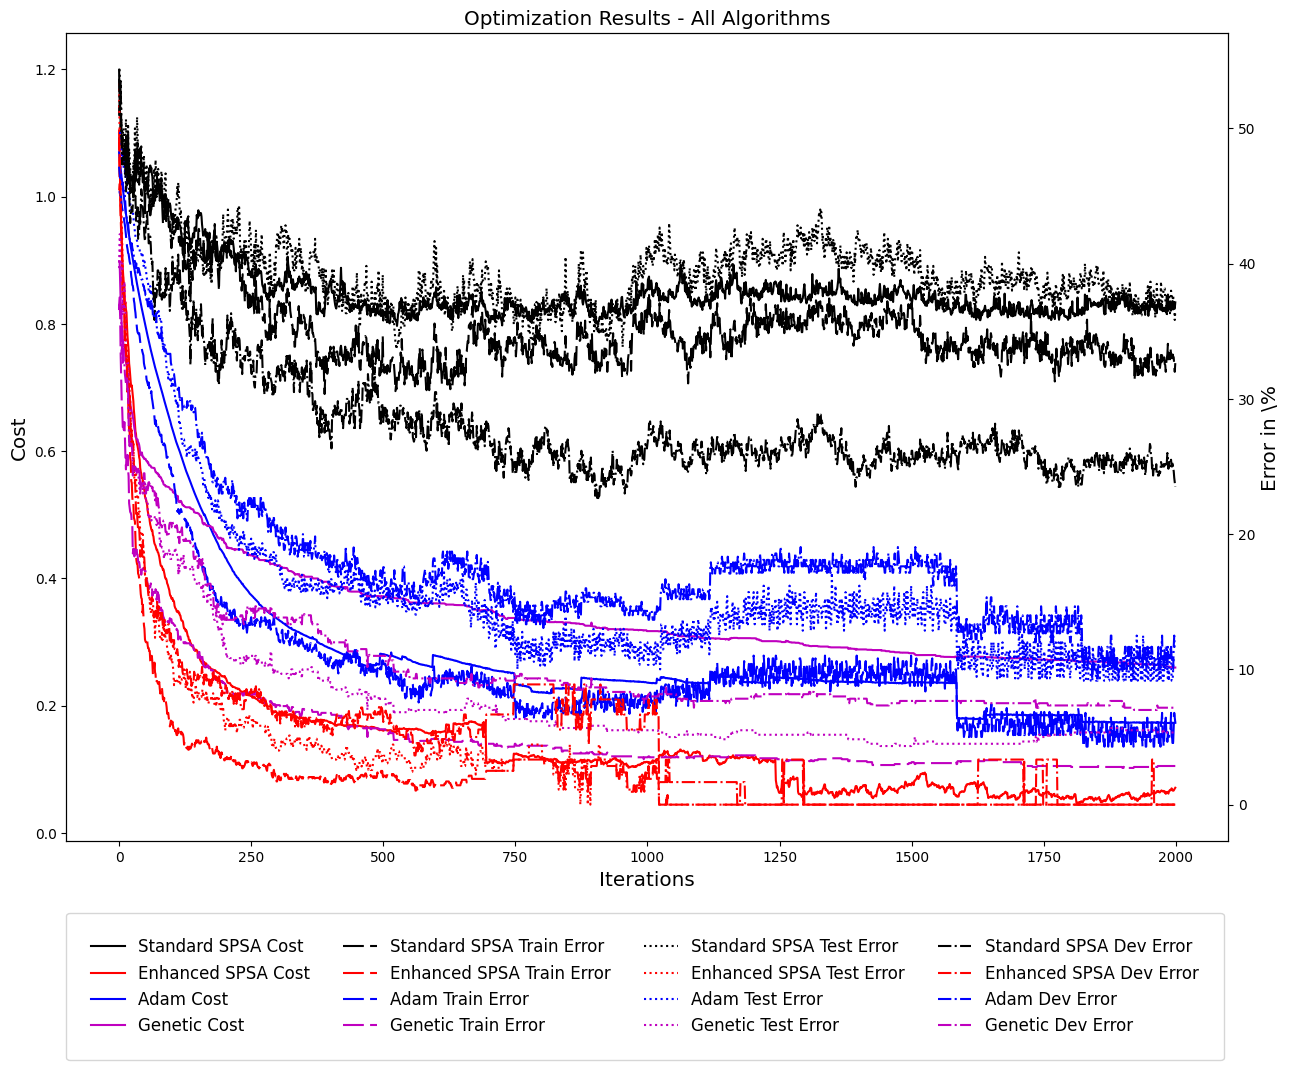

In [ ]:
#****************************************************
# Summary plot for all four Algorithms
#****************************************************
from matplotlib import pyplot as plt

# Create a figure and axis for the primary plot
fig, ax1 = plt.subplots(figsize=(13, 13))  # Set the plot size to 13x8 inches

# -, --, -., :, ., 

# Plot cost history for all four algorithms
ax1.plot(range(len(cost_history_mean_spsa)), cost_history_mean_spsa, 'k', markersize=4, label='Standard SPSA Cost')
ax1.plot(range(len(cost_history_mean_spsa_enh)), cost_history_mean_spsa_enh, 'r', markersize=4, label='Enhanced SPSA Cost')
ax1.plot(range(len(cost_history_mean_adam_opt)), cost_history_mean_adam_opt, 'b', markersize=4, label='Adam Cost')
ax1.plot(range(len(cost_history_mean_ga)), cost_history_mean_ga, 'm', markersize=4, label='Genetic Cost')
ax1.set_ylabel(r"Cost", fontsize='x-large')  # Label the y-axis for cost
ax1.set_xlabel(r"Iterations", fontsize='x-large')  # Label the x-axis for iterations

# Create a secondary y-axis that shares the x-axis for error plotting
ax2 = ax1.twinx()
ax2.set_ylabel(r"Error in \%", fontsize='x-large')  # Label the secondary y-axis for error

# Create custom linestyle for error train data
custom_styles = {
    'longdash': (0, (10, 3)),
    'shortdash': (0, (5, 2)),
    'dashdotdot': (0, (3, 2, 1, 2))
}

# Plot training error for all four algorithms
ax2.plot(range(len(error_train_history_mean_spsa)), error_train_history_mean_spsa, linestyle=custom_styles['longdash'], color='k', markersize=4, label='Standard SPSA Train Error')
ax2.plot(range(len(error_train_history_mean_spsa_enh)), error_train_history_mean_spsa_enh, linestyle=custom_styles['longdash'], color='r', markersize=4, label='Enhanced SPSA Train Error')
ax2.plot(range(len(error_train_history_mean_adam_opt)), error_train_history_mean_adam_opt, linestyle=custom_styles['longdash'], color='b', markersize=4, label='Adam Train Error')
ax2.plot(range(len(error_train_history_mean_ga)), error_train_history_mean_ga, linestyle=custom_styles['longdash'], color='m', markersize=4, label='Genetic Train Error')

# Plot testing error for all four algorithms
ax2.plot(range(len(error_test_history_mean_spsa)), error_test_history_mean_spsa, ':k', markersize=4, label='Standard SPSA Test Error')
ax2.plot(range(len(error_test_history_mean_spsa_enh)), error_test_history_mean_spsa_enh, ':r', markersize=4, label='Enhanced SPSA Test Error')
ax2.plot(range(len(error_test_history_mean_adam_opt)), error_test_history_mean_adam_opt, ':b', markersize=4, label='Adam Test Error')
ax2.plot(range(len(error_test_history_mean_ga)), error_test_history_mean_ga, ':m', markersize=4, label='Genetic Test Error')

# Plot dev error for all four algorithms
ax2.plot(range(len(error_dev_history_mean_spsa)), error_dev_history_mean_spsa, '-.k', markersize=4, label='Standard SPSA Dev Error')
ax2.plot(range(len(error_dev_history_mean_spsa_enh)), error_dev_history_mean_spsa_enh, '-.r', markersize=4, label='Enhanced SPSA Dev Error')
ax2.plot(range(len(error_dev_history_mean_adam_opt)), error_dev_history_mean_adam_opt, '-.b', markersize=4, label='Adam Dev Error')
ax2.plot(range(len(error_dev_history_mean_ga)), error_dev_history_mean_ga, '-.m', markersize=4, label='Genetic Dev Error')

# Combine legends from both axes into one
handles1, labels1 = ax1.get_legend_handles_labels()  # Get legend handles and labels from ax1
handles2, labels2 = ax2.get_legend_handles_labels()  # Get legend handles and labels from ax2
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2

# Add a single legend outside the plot
fig.legend(
    combined_handles,
    combined_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.3),
    fontsize='large',
    ncol=4,
    frameon=True,
    borderpad=1.5
)

# Add a title to the plot
plt.title('Optimization Results - All Algorithms', fontsize='x-large')

# Adjust layout to accommodate legends outside the plot
plt.tight_layout(rect=[0, .3, 1, 1])  # Leave space at the bottom

# Save the plot to a file with high resolution
plt.savefig('MC_task_Results_All_Algorithms.png', dpi=300, facecolor='white', bbox_inches='tight')

# Display the plot
plt.show()


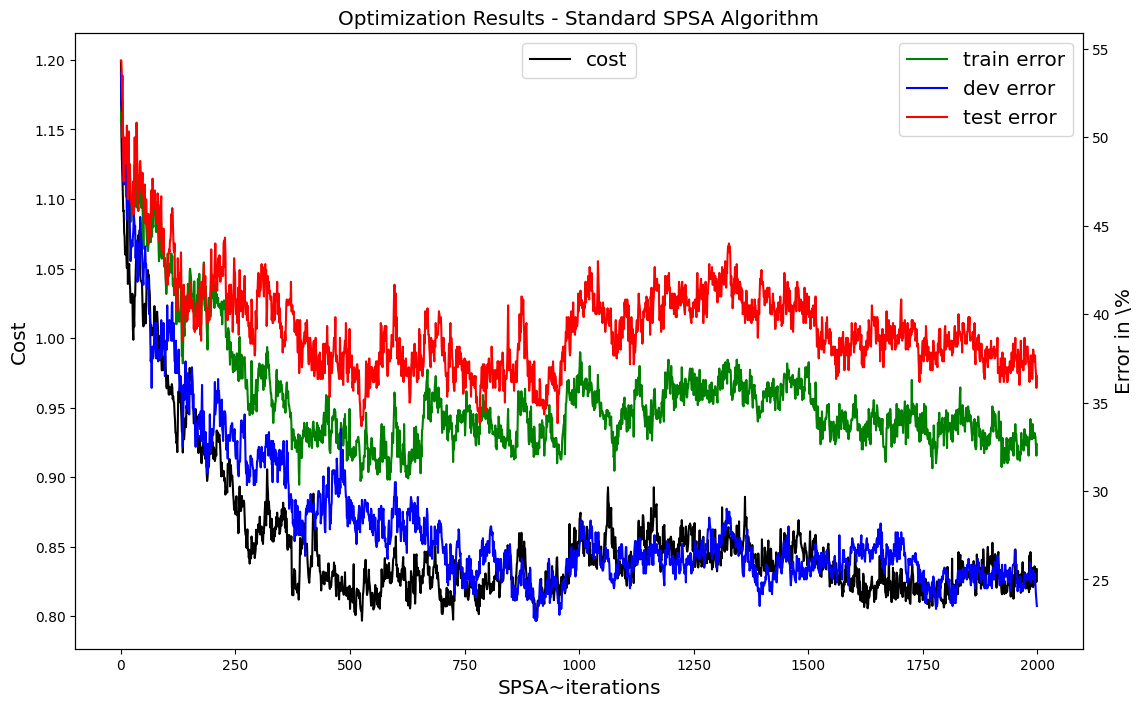

In [ ]:
#****************************************************
# Summary plot
#****************************************************
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(13, 8))

ax1.plot(range(len(cost_history_mean_spsa)), cost_history_mean_spsa, '-k', markersize=4, label='cost')
ax1.set_ylabel(r"Cost", fontsize='x-large')
ax1.set_xlabel(r"SPSA~iterations", fontsize='x-large')
ax1.legend(loc='upper center', fontsize='x-large')

ax2 = ax1.twinx()
ax2.set_ylabel(r"Error in \%", fontsize='x-large')
ax2.plot(range(len(error_train_history_mean_spsa)), error_train_history_mean_spsa, '-g', markersize=4, label='train error')
ax2.plot(range(len(error_dev_history_mean_spsa)), error_dev_history_mean_spsa, '-b', markersize=4, label='dev error')
ax2.plot(range(len(error_test_history_mean_spsa)), error_test_history_mean_spsa, '-r', markersize=4, label='test error')
ax2.legend(loc='upper right', fontsize='x-large')


plt.title('Optimization Results - Standard SPSA Algorithm', fontsize='x-large')
plt.savefig('MC_task_ECS_Results.png', dpi=300, facecolor='white')  
plt.show()

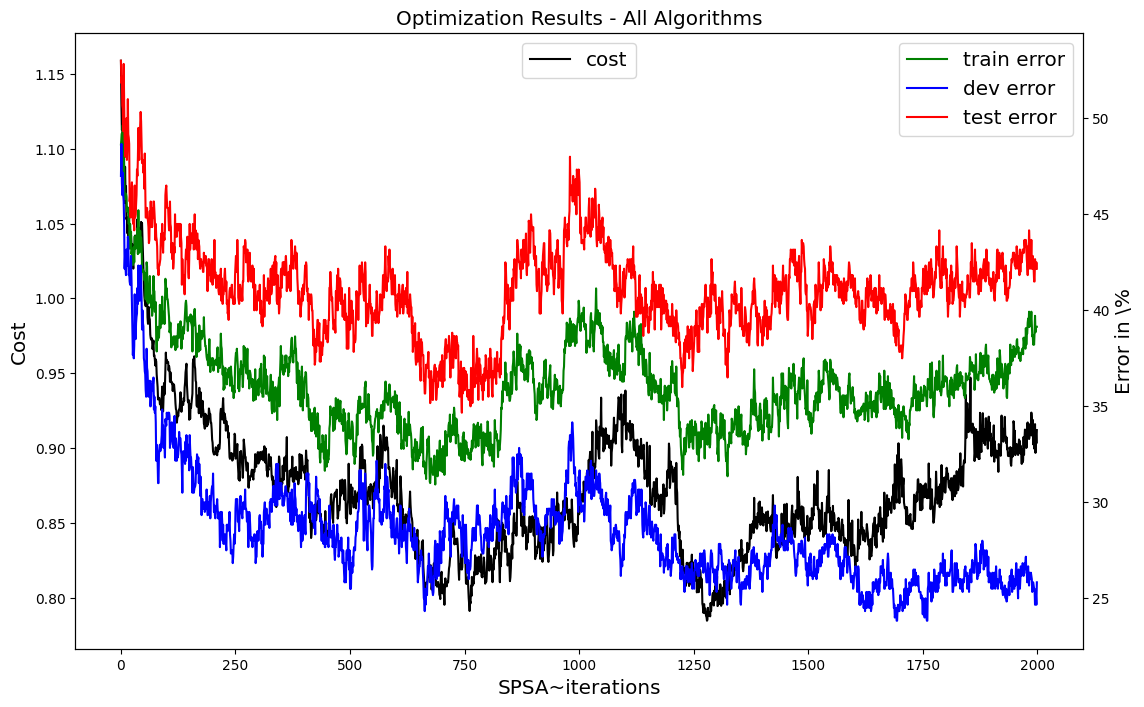

In [ ]:
#****************************************************
# Summary plot
#****************************************************
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(13, 8))

ax1.plot(range(len(cost_history_mean_spsa_enh)), cost_history_mean_spsa, '-k', markersize=4, label='cost')
ax1.set_ylabel(r"Cost", fontsize='x-large')
ax1.set_xlabel(r"SPSA~iterations", fontsize='x-large')
ax1.legend(loc='upper center', fontsize='x-large')

ax2 = ax1.twinx()
ax2.set_ylabel(r"Error in \%", fontsize='x-large')
ax2.plot(range(len(error_train_history_mean_spsa)), error_train_history_mean_spsa, '-g', markersize=4, label='train error')
ax2.plot(range(len(error_dev_history_mean_spsa)), error_dev_history_mean_spsa, '-b', markersize=4, label='dev error')
ax2.plot(range(len(error_test_history_mean_spsa)), error_test_history_mean_spsa, '-r', markersize=4, label='test error')
ax2.legend(loc='upper right', fontsize='x-large')


plt.title('Optimization Results - All Algorithms', fontsize='x-large')
plt.savefig('MC_task_ECS_Results.png', dpi=300, facecolor='white')  
plt.show()

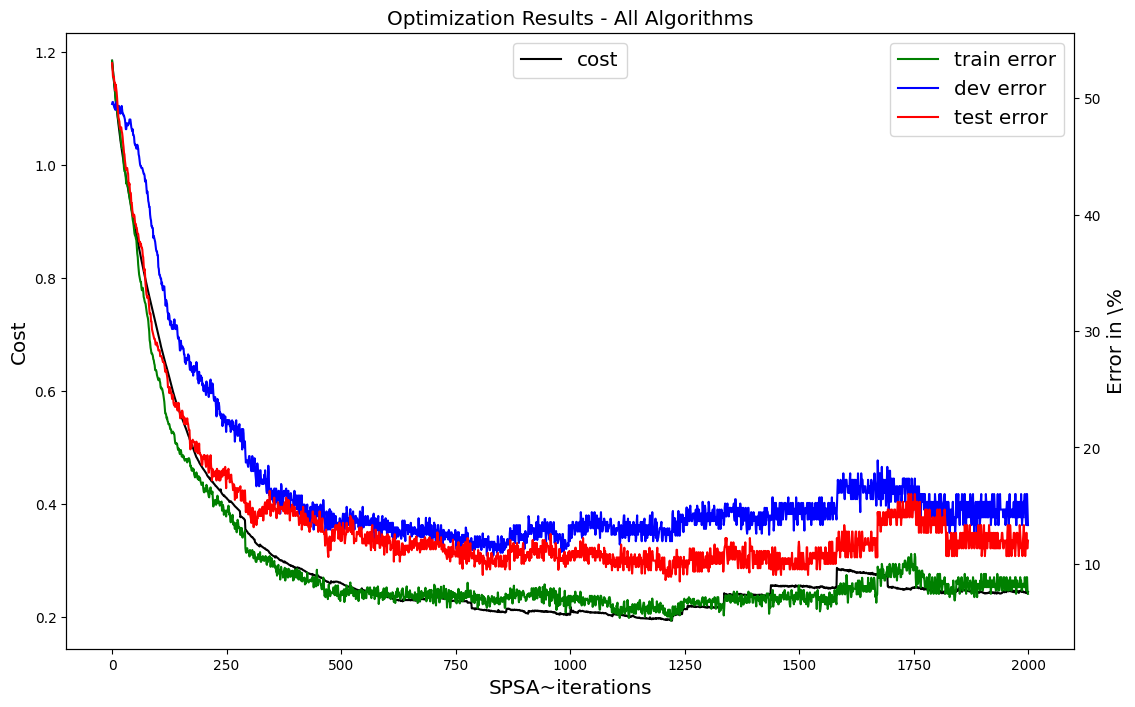

In [ ]:
#****************************************************
# Summary plot
#****************************************************
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(13, 8))

ax1.plot(range(len(cost_history_mean_adam_opt)), cost_history_mean_adam_opt, '-k', markersize=4, label='cost')
ax1.set_ylabel(r"Cost", fontsize='x-large')
ax1.set_xlabel(r"SPSA~iterations", fontsize='x-large')
ax1.legend(loc='upper center', fontsize='x-large')

ax2 = ax1.twinx()
ax2.set_ylabel(r"Error in \%", fontsize='x-large')
ax2.plot(range(len(error_train_history_mean_adam_opt)), error_train_history_mean_adam_opt, '-g', markersize=4, label='train error')
ax2.plot(range(len(error_dev_history_mean_adam_opt)), error_dev_history_mean_adam_opt, '-b', markersize=4, label='dev error')
ax2.plot(range(len(error_test_history_mean_adam_opt)), error_test_history_mean_adam_opt, '-r', markersize=4, label='test error')
ax2.legend(loc='upper right', fontsize='x-large')


plt.title('Optimization Results - All Algorithms', fontsize='x-large')
plt.savefig('MC_task_ECS_Results.png', dpi=300, facecolor='white')  
plt.show()

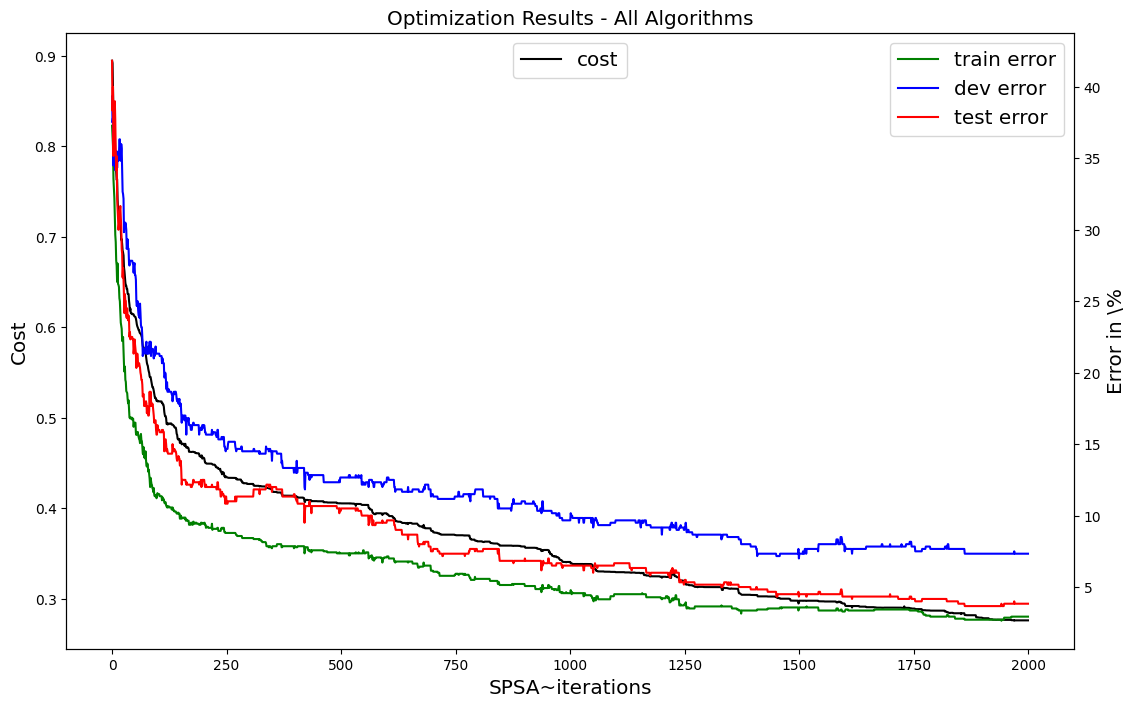

In [ ]:
#****************************************************
# Summary plot
#****************************************************
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(13, 8))

ax1.plot(range(len(cost_history_mean_ga)), cost_history_mean_ga, '-k', markersize=4, label='cost')
ax1.set_ylabel(r"Cost", fontsize='x-large')
ax1.set_xlabel(r"SPSA~iterations", fontsize='x-large')
ax1.legend(loc='upper center', fontsize='x-large')

ax2 = ax1.twinx()
ax2.set_ylabel(r"Error in \%", fontsize='x-large')
ax2.plot(range(len(error_train_history_mean_ga)), error_train_history_mean_ga, '-g', markersize=4, label='train error')
ax2.plot(range(len(error_dev_history_mean_ga)), error_dev_history_mean_ga, '-b', markersize=4, label='dev error')
ax2.plot(range(len(error_test_history_mean_ga)), error_test_history_mean_ga, '-r', markersize=4, label='test error')
ax2.legend(loc='upper right', fontsize='x-large')


plt.title('Optimization Results - All Algorithms', fontsize='x-large')
plt.savefig('MC_task_ECS_Results.png', dpi=300, facecolor='white')  
plt.show()

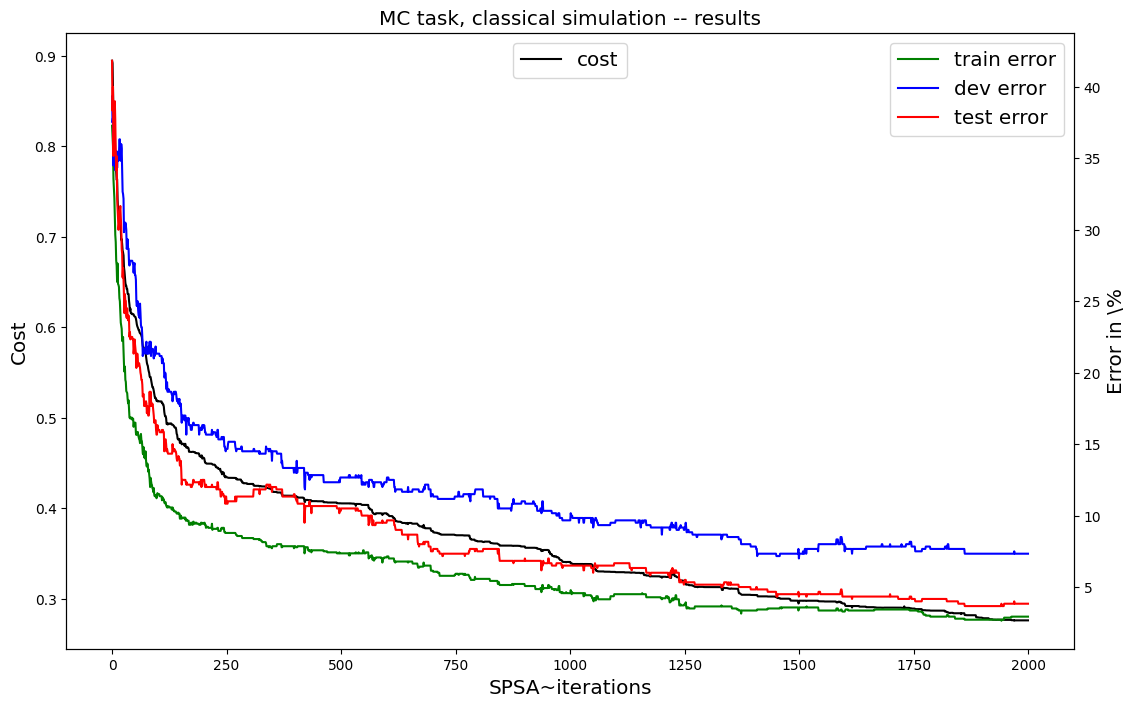

In [ ]:
#****************************************************
# Summary plot
#****************************************************
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(13, 8))

ax1.plot(range(len(cost_history_mean_ga)), cost_history_mean_ga, '-k', markersize=4, label='cost')
ax1.set_ylabel(r"Cost", fontsize='x-large')
ax1.set_xlabel(r"SPSA~iterations", fontsize='x-large')
ax1.legend(loc='upper center', fontsize='x-large')

ax2 = ax1.twinx()
ax2.set_ylabel(r"Error in \%", fontsize='x-large')
ax2.plot(range(len(error_train_history_mean_ga)), error_train_history_mean_ga, '-g', markersize=4, label='train error')
ax2.plot(range(len(error_dev_history_mean_ga)), error_dev_history_mean_ga, '-b', markersize=4, label='dev error')
ax2.plot(range(len(error_test_history_mean_ga)), error_test_history_mean_ga, '-r', markersize=4, label='test error')
ax2.legend(loc='upper right', fontsize='x-large')


plt.title('MC task, classical simulation -- results', fontsize='x-large')
plt.savefig('MC_task_ECS_Results.png', dpi=300, facecolor='white')  
plt.show()